<a href="https://colab.research.google.com/github/luishpinto/mt_connect/blob/main/mt_connect_full_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  !rm -rf mt_connect
  !git clone 'https://github.com/luishpinto/mt_connect.git' --quiet
  print('MT_Connect directory is cloned')
except:
  print('MT_Connect directory is already cloned')

MT_Connect directory is cloned


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 8

In [4]:
f_names = !ls -1 ./mt_connect/full_data

In [5]:
files = []
df = pd.DataFrame()

for name in f_names:
  f = pd.ExcelFile('./mt_connect/full_data/' + name, engine = 'openpyxl')
  files.append(f)
  df = pd.concat([df, pd.read_excel(f, f.sheet_names[0])])
  # df.append(pd.read_excel(f, f.sheet_names[0]))
df.columns = ['equipment', 'date', 'key', 'type', 'value', 'cycle', 'status']
df['type'] = df['type'].str.lower()
df = df.drop(['key', 'status'], axis = 1)
f.close()

In [15]:
class bplot(object):

  def __init__(self, title, x_label, v_name, df, n = int(1e3), resolution = 10):
    self.title = title
    self.x_label = x_label
    self.v_name = v_name
    self.df = df
    self.n = n

    self.data = []
    self.bplt_data = []
    self.percentile = []

    for i in range(df['cycle'].max()):
      self.data.append(self.reshape(self.df.loc[lambda df: (df['type'] == self.v_name) & (df['cycle'] == (i + 1)), ['value']].values, self.n))

    self.data = np.array(self.data, dtype = 'float64').reshape(-1, self.n)
    self.bins = np.arange(0.5 * resolution, np.round(self.data.max() / resolution) * resolution, resolution, dtype = 'int32')

    for i in range(self.data.shape[0]):
      self.bplt_data.append(np.histogram(self.data[i], bins = self.bins, density = True)[0])

    self.bplt_data = np.array(self.bplt_data)

    self.percentile = np.percentile(self.bplt_data, [2.5, 97.5], axis = 0)

    fig, ax = plt.subplots(figsize = (8, 4))
    # plt.boxplot(self.bplt_data, labels = self.bins[:-1], showfliers = True, zorder = 30)
    ax.fill_between(self.bins[:-1], self.percentile[0], self.percentile[1],
                    color = 'cyan', alpha = 0.5, step = 'mid')
    plt.step(self.bins[:-1], self.percentile[0],
             'k--', lw = 0.75, where = 'mid')
    plt.step(self.bins[:-1], self.percentile[1],
             'k--', lw = 0.75, where = 'mid')
    plt.yscale('log')
    # plt.ylim(1.0e-5, plt.ylim()[1])
    plt.xlabel(self.x_label)
    plt.ylabel('Density')
    plt.title(self.title + ' Load Distribution')
    plt.tight_layout()
    plt.savefig(self.v_name + '-distribution.png', dpi = 300)
    plt.show()

  def reshape(self, x, n):
    u = []
    u.append(x[0])
    for i in range(2, n):
      u.append(x[int(i * (x.shape[0] / (n + 1)))])

    u.append(x[-1])

    return np.array(u)

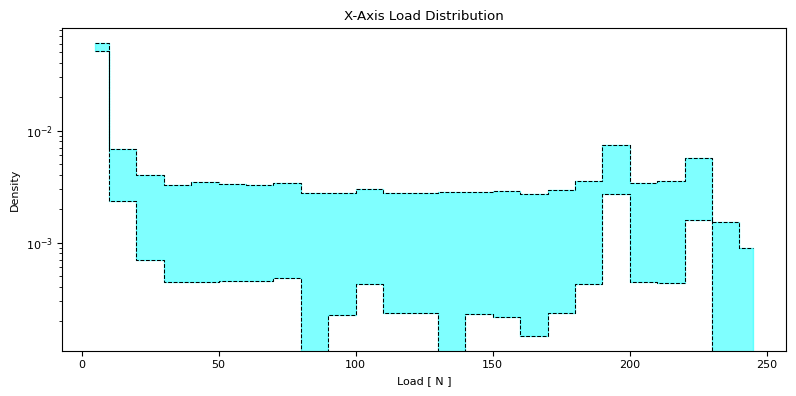

In [11]:
x_load = bplot('X-Axis', 'Load [ N ]', 'xload', df, n = int(2.0e3), resolution = 10)

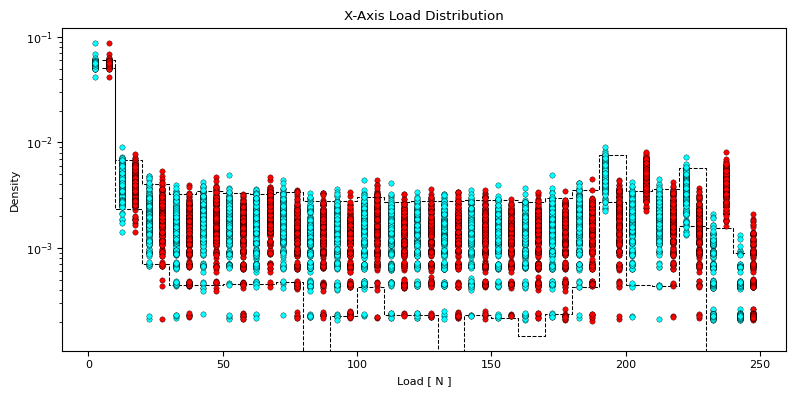

In [14]:
gain = 0.05

fig, ax = plt.subplots(figsize = (8, 4))
for i in range(x_load.data.shape[0]):
  plt.scatter(x_load.bins[:-1] - 2.50, np.histogram(x_load.data[i], bins = x_load.bins, density = True)[0],
              lw = 0.25, s = 15, edgecolors = 'black', color = 'cyan', zorder = 50)
  plt.scatter(x_load.bins[:-1] + 2.50, np.histogram(x_load.data[i] * (1 + gain), bins = x_load.bins, density = True)[0],
              lw = 0.25, s = 15, edgecolors = 'black', color = 'red', zorder = 50)
plt.step(x_load.bins[:-1],
         np.percentile(x_load.bplt_data, 2.5, axis = 0),
         'k--', lw = 0.75, where = 'mid')
plt.step(x_load.bins[:-1],
         np.percentile(x_load.bplt_data, 97.5, axis = 0),
         'k--', lw = 0.75, where = 'mid')
plt.yscale('log')
plt.xlabel(x_load.x_label)
plt.ylabel('Density')
plt.title(x_load.title + ' Load Distribution')
plt.tight_layout()
plt.savefig(x_load.v_name + '-distribution ( modified ).png', dpi = 300)
plt.show()